In [10]:
# Lab 09– Ensemble Learning - Boosting
# Learning Outcomes
# By the end of this lab, students will be able to:
# Implement AdaBoost
# Build sklearn pipeline with preprocessing + classifier
# Evaluate models using accuracy, ROC AUC, and confusion matrix.
# P — Project
# Preprocess Churn dataset
# Train/test split.
# Fit:
# Implement AdaBoost
# Build sklearn pipeline with preprocessing + classifier
# Evaluate models using accuracy, precision, recall, f1-score, ROC AUC, and confusion
# matrix.
# Resources
# Sklearn Model Evaluation – https://scikitlearn. org/stable/modules/model_evaluation.html
# Confusion Matrix in Sklearn – https://scikitlearn.
# org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

print("Libraries imported.")

Libraries imported.


In [12]:
# 1. Load Data
dataset_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(dataset_url)
    print(f"Dataset loaded.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Data Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Preprocessing
df["Churn"] = df["Churn"].astype(str).str.strip()
try:
    y = df["Churn"].map({
        "Yes": 1, "No": 0
    }).astype(int)
except Exception as e:
    print(f"Error mapping target variable 'Churn'. Error: {e}")
    print("Unique values in 'Churn' column:", df['Churn'].unique())
    exit()

X = df.drop(columns=["Churn", "customerID"])
print("\nShape:", df.shape)
print("\nHead of features:")
print(X.head(3))

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ],
    remainder='passthrough'
)

print(f"\n# numeric features: {len(num_cols)}")
print(f"# categorical features: {len(cat_cols)}")
print("Preprocessing done.")

Dataset loaded.

Shape: (7032, 21)

Head of features:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   

  PaperlessBilling     PaymentMethod  MonthlyCharges  TotalCharges  
0              Yes  El

In [13]:
# 2. Train/Test Split
strata = y if y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=strata
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Target balance (train):", y_train.mean().round(4))
print("Target balance (test):", y_test.mean().round(4))

Train shape: (5625, 19)  Test shape: (1407, 19)
Target balance (train): 0.2658
Target balance (test): 0.2658


In [14]:
# 3. Build Pipeline
print("\n--- Building AdaBoost Pipeline ---")

base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

adaboost_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,       # 50 is a common default
    learning_rate=1.0,
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', adaboost_model)
])

print("Pipeline created.")


--- Building AdaBoost Pipeline ---
Pipeline created.


In [15]:
# 4. Fit Model
print("\n--- Training Model ---")
try:
    pipeline.fit(X_train, y_train)
    print("Pipeline fitting completed successfully.")
except Exception as e:
    print(f"Error during model fitting: {e}")
    exit()



--- Training Model ---
Pipeline fitting completed successfully.



--- Model Evaluation on Test Set ---
Accuracy:    0.7903
Precision:   0.6262
Recall:      0.5241
F1-Score:    0.5706
ROC AUC:     0.8356

--- Confusion Matrix ---
Displaying Confusion Matrix plot...


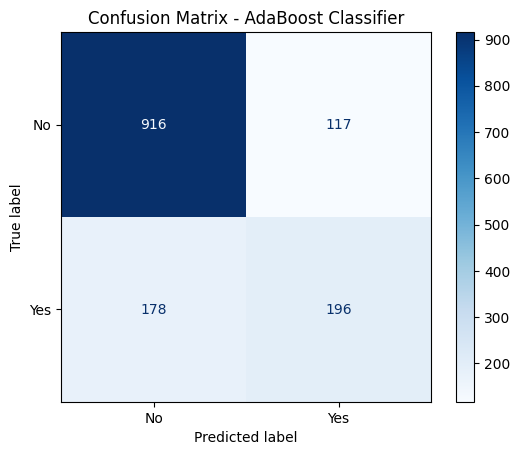


Execution finished.


In [16]:
# 5. Evaluate Model
print("\n--- Model Evaluation on Test Set ---")

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

try:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"ROC AUC:     {roc_auc:.4f}")

    # Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    
    display_labels = ['No' if i == 0 else 'Yes' for i in pipeline.classes_]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - AdaBoost Classifier")
    print("Displaying Confusion Matrix plot...")
    plt.show()

except Exception as e:
    print(f"Error during model evaluation: {e}")

print("\nExecution finished.")